In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [2]:
protoFile = 'pose_deploy_linevec.prototxt'
weightsFile = 'pose_iter_440000.caffemodel'
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

## 找关键点

In [3]:
#利用NMS找到关键点
def getKeypoints(probMap,threshold=0.1):
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    _,contours,_ = cv2.findContours(mapMask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask,cnt,1)
        maskProbMap = mapSmooth*blobMask
        _,maxVal,_,maxLoc = cv2.minMaxLoc(maskProbMap)
        keypoints.append(maxLoc+(probMap[maxLoc[1],maxLoc[0]],))#位置和置信度
    return keypoints
## 提取人体关键点
def get_joint_kps(output):
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoints_id = 0
    threshold = 0.1
    for part in range(nPoints):
        probMap=output[0,part,:,:]
        probMap = cv2.resize(probMap,(img.shape[1],img.shape[0]))
        keypoints = getKeypoints(probMap,threshold)
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i]+(keypoints_id,)) #所有人的18个关节位置、置信度、id
            keypoints_list = np.vstack([keypoints_list,keypoints[i]])
            keypoints_id += 1
        detected_keypoints.append(keypoints_with_id)
    return detected_keypoints,keypoints_list

## 对应人的关键点

In [4]:
def get_valid_pairs(output,detected_keypoints):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    for k in range(len(mapIdx)):
        #两个可能连接的关节
        pafA = output[0,mapIdx[k][0],:,:] #第k组连接关节的第一个关节PAF
        pafB = output[0,mapIdx[k][1],:,:] #第k组连接关节的第二个关节PAF
        pafA = cv2.resize(pafA,(frameWidth,frameHeight))
        pafB = cv2.resize(pafB,(frameWidth,frameHeight))
        #找到这两个关节的位置
        candA = detected_keypoints[POSE_PAIRS[k][0]] #找到第一个关节的位置(所有人)
        candB = detected_keypoints[POSE_PAIRS[k][1]] #找到第二个关节的位置(所有人)
        nA = len(candA)
        nB = len(candB)
        #使用公式计算亲和场的得分
        if(nA!=0 and nB!=0): #如果有这两个关节
            valid_pair = np.zeros((0,3))
            for i in range(nA): #对于第一个关节的所有人遍历
                max_j = -1
                maxScore = -1
                found = 0
                for j in range(nB): #第二个关节的所有人遍历
                    d_ij = np.subtract(candB[j][:2],candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if(norm):
                        d_ij = d_ij/norm #公式(10的d部分)
                    else:
                        continue
                    interp_coord = list(zip(np.linspace(candA[i][0],candB[j][0],num=n_interp_samples),
                                           np.linspace(candA[i][1],candB[j][1],num=n_interp_samples)))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])),int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])),int(round(interp_coord[k][0]))]])
                    paf_scores = np.dot(paf_interp,d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    if(len(np.where(paf_scores>paf_score_th)[0])/n_interp_samples)>conf_th:
                        if(avg_paf_score>maxScore):
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                if found:
                    valid_pair = np.append(valid_pair,[[candA[i][3],candB[max_j][3],maxScore]],axis=0) #被连接的肢体的关键点索引
            valid_pairs.append(valid_pair)
        else:#如果关节被遮挡等原因，导致不存在
            invalid_pairs.append(k)
            valid_pairs.append([])        
    return valid_pairs,invalid_pairs
# 根据获得的能被连接的关键点对，把坐标也对应好
def getPersonwiseKeyPoints(valid_pairs,invalid_pairs,keypoints_list):
    personwiseKeypoints = -1 * np.ones((0,19))
    for k in range(len(mapIdx)): #遍历有效的关节连接
        if(k not in invalid_pairs): #当前关节存在
            partAs = valid_pairs[k][:,0] #所有人第一个关节索引
            partBs = valid_pairs[k][:,1] #所有人第二个关节索引
            indexA,indexB = np.array(POSE_PAIRS[k]) #对应肢体的关键点索引
            for i in range(len(valid_pairs[k])): #当前关节有多少个数据点(人)
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):#遍历人                    
                    if(personwiseKeypoints[j][indexA]==partAs[i]):
                        person_idx = j
                        found=1
                        break
                if(found):
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int),2]+valid_pairs[k][i][2]
                elif not found and k<17:
                    row = -1*np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int),2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints,row])
    return personwiseKeypoints

## 测试

In [5]:
img = cv2.imread('./examples/media/COCO_val2014_000000000328.jpg')
frameWidth = img.shape[1]
frameHeight = img.shape[0]

In [6]:
net = cv2.dnn.readNetFromCaffe(protoFile,weightsFile)

In [7]:
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)
inBlob = cv2.dnn.blobFromImage(img,1.0/255.0,(inWidth,inHeight),(0,0,0),swapRB=False,crop=False)
net.setInput(inBlob)
output=net.forward()
print(output.shape)

(1, 57, 46, 60)


(-0.5, 639.5, 490.5, -0.5)

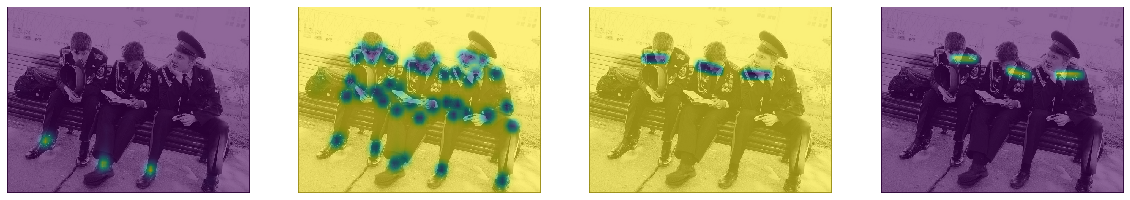

In [36]:
#可视化
plt.figure(figsize=[20,20])
plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.resize(output[0, 10, :, :], (frameWidth, frameHeight)), alpha=0.6)
plt.axis("off")
plt.subplot(142)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.resize(output[0, 18, :, :], (frameWidth, frameHeight)), alpha=0.6)
plt.axis("off")
plt.subplot(143)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.resize(output[0, 31, :, :], (frameWidth, frameHeight)), alpha=0.6)
plt.axis("off")
plt.subplot(144)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.resize(output[0, 39, :, :], (frameWidth, frameHeight)), alpha=0.6)
plt.axis("off")

In [8]:
#detected_keypoints:存储关节的位置、置信度、序号；每个关节自成一组
#keypoints_list:把所有关节的位置、置信度放一起
detected_keypoints,keypoints_list = get_joint_kps(output)

In [41]:
keypoints_list.shape

(53, 3)

(-0.5, 639.5, 490.5, -0.5)

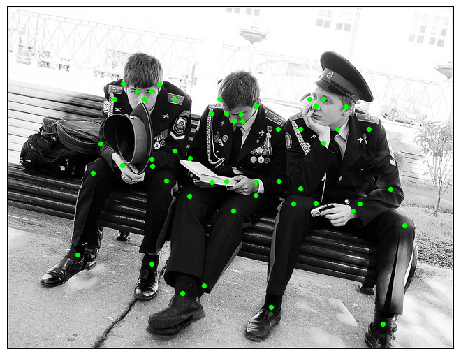

In [42]:
#可视化关键点
img_show = img.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(img_show,detected_keypoints[i][j][0:2],3,[0,255,0],-1,cv2.LINE_AA)
plt.figure(figsize=[8,8])
plt.imshow(img_show)
plt.axis('off')

In [11]:
#valid_pairs存储可成对的关节索引，所有人的每个关节成一组，比如3个人的第一个关节，组成一个3*3的矩阵
valid_pairs,invalid_pairs = get_valid_pairs(output,detected_keypoints)

(-0.5, 639.5, 490.5, -0.5)

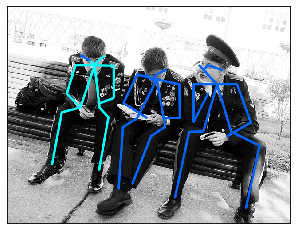

In [75]:
img_show = img.copy()
for pair in valid_pairs:
    for i in range(pair.shape[0]):
        conA = keypoints_list[int(pair[i][0])].astype(int)
        conB = keypoints_list[int(pair[i][1])].astype(int)

        cv2.line(img_show, (conA[0], conA[1]), (conB[0], conB[1]), colors[i], 3, cv2.LINE_AA)

plt.imshow(img_show)
plt.axis('off')

In [13]:
personwiseKeypoints = getPersonwiseKeyPoints(valid_pairs,invalid_pairs,keypoints_list)

not found
not found
not found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


In [14]:
print(personwiseKeypoints)

[[ 1.          3.          6.          9.         14.         16.
  18.         21.         24.         27.         30.         33.
  36.         39.         43.         46.         -1.         50.
  25.16836102]
 [ 0.          4.          7.         10.         12.         15.
  19.         22.         25.         28.         31.         34.
  37.         40.         42.         45.         -1.         51.
  22.83992412]
 [ 2.          5.          8.         11.         13.         17.
  20.         23.         26.         29.         32.         35.
  38.         41.         44.         47.         49.         52.
  25.00522498]]


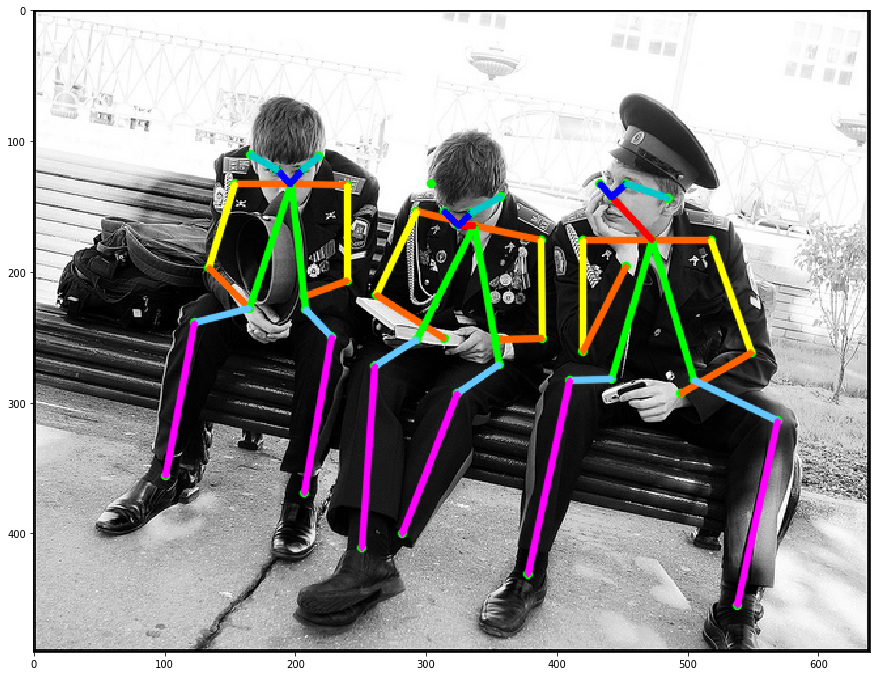

In [15]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(img_show, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(img_show[:,:,[2,1,0]])